In [1]:
%load_ext autoreload
%autoreload 2
import barcoderegression
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.ndimage
import tqdm.notebook
import numpy.random as npr
import ipywidgets
import skimage
import skimage.feature

from barcoderegression.plotting import AnimAcross

%matplotlib inline

def rbyc(A,cb=True):
    mx=A.max()
    with AnimAcross(columns=A.shape[-1]) as a:
        for c in range(A.shape[-2]):
            for r in range(A.shape[-1]):
                ~a
                mappable=plt.imshow(A[:,:,c,r],vmin=0,vmax=mx)
                if cb:
                    a.cb(mappable)
                plt.axis('off')
    
def rbycs(*args):
    def go(i):
        rbyc(args[i])
    ipywidgets.interact(go,i=list(range(len(args))))
    
def frames(model):
    frame_loadings=model.frame_loadings()
    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(frame_loadings[:,:,j]))
            plt.axis('off')

def spatials(model,spdims,blurred=True):
    F = model.F_scaled(blurred=blurred)

    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(F[:,j].reshape(spdims)))

# simulate data

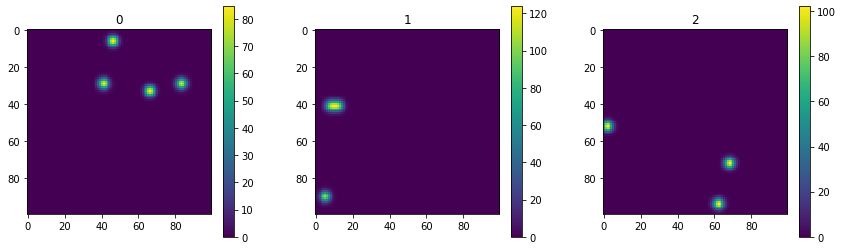

In [2]:
spdims=(100,100)
R=6
C=4
J=3

model,X,X_without_noise = barcoderegression.simulations.simulation(
    R=R,C=C,J=J,spatial_dims=spdims,
    num_spots=10,blursize=[2,2],noise=3,rho=npr.rand(C),
    anoise=.01,bnoise=.01,
    lam=0.1,varphinoise=5)

spatials(model,spdims)

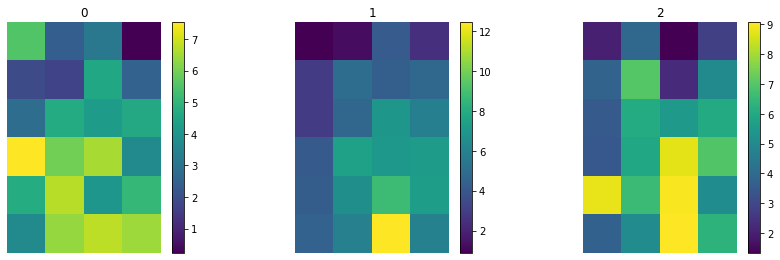

In [3]:
frames(model)

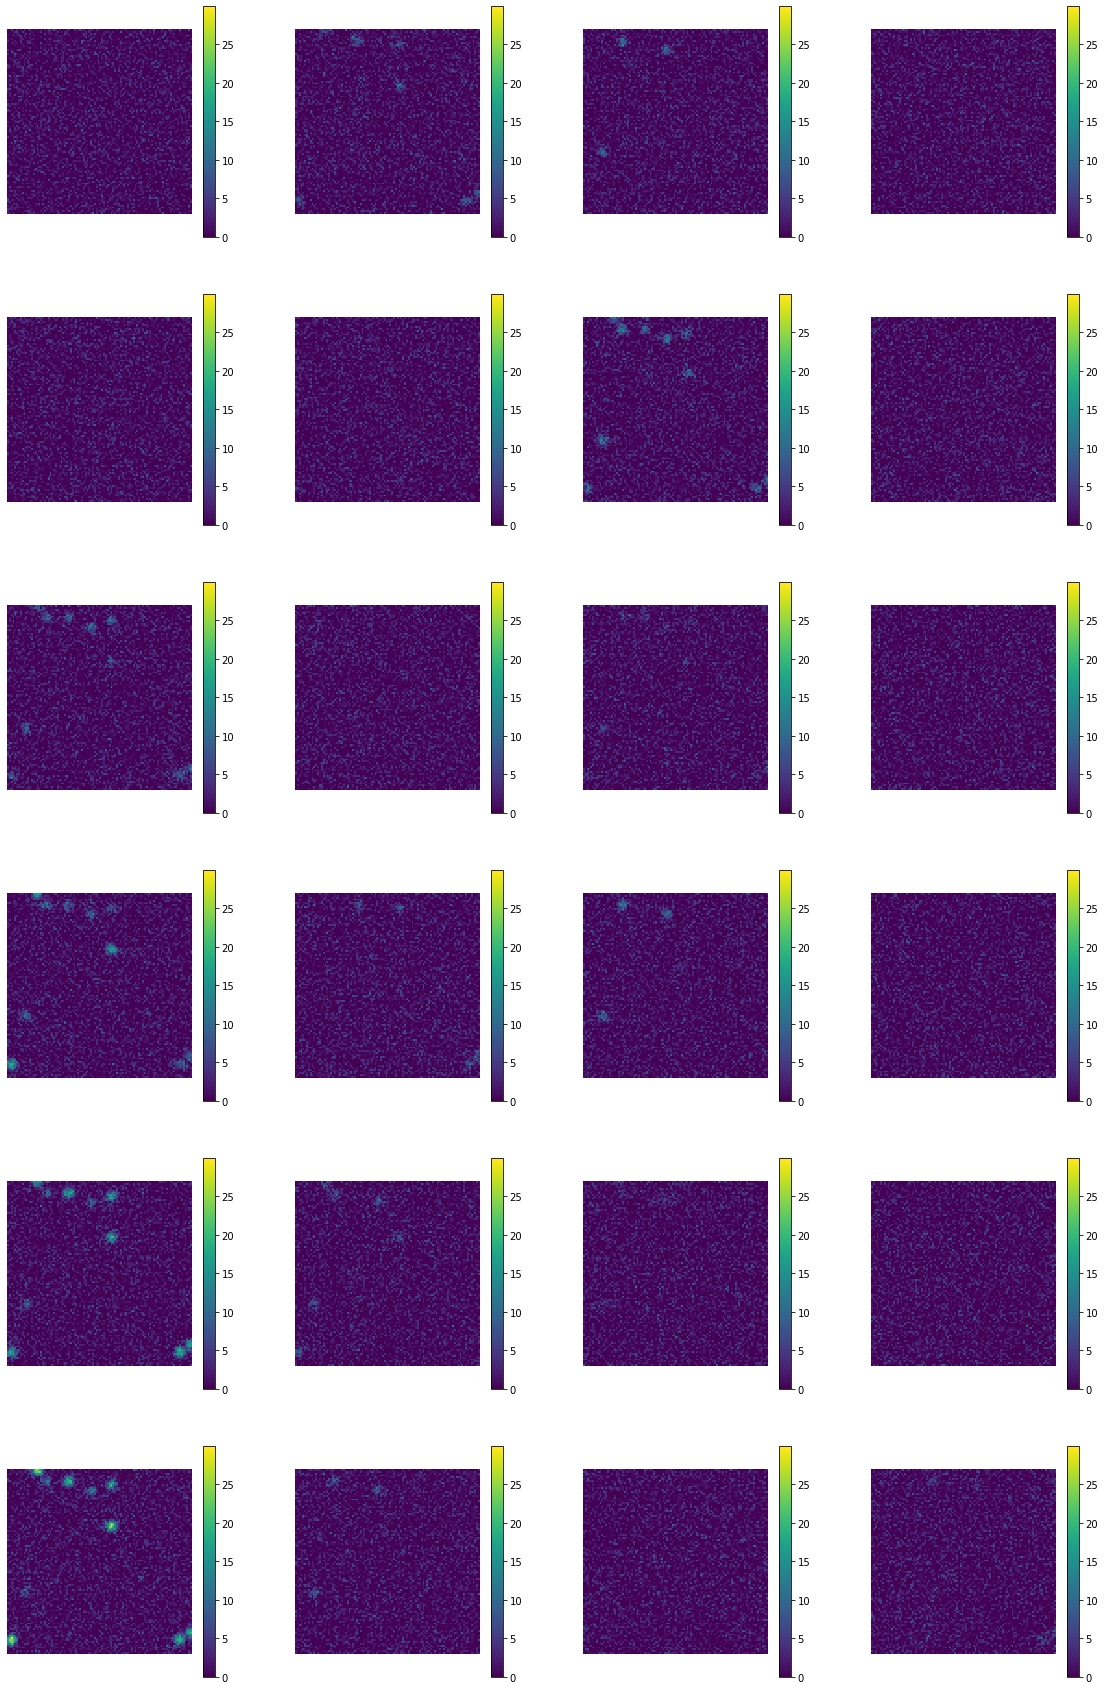

In [4]:
rbyc(X)

In [5]:
Xrav=X.reshape((-1,R,C))
lossinfo=model.loss(Xrav)
bestloss=lossinfo['loss']
print('final reconstruction loss per obs',lossinfo['reconstruction']/model.nobs)
print('final L1 loss perobs',model.lam*lossinfo['l1']/model.nobs)
print('true loss perobs',lossinfo['loss']) 

final reconstruction loss per obs 4.683529956886393
final L1 loss perobs 0.008703279736887127
true loss perobs 4.692233236623281


# try to learn loadings


we never went the wrong way!
final reconstruction loss per obs 4.40390346635567
final L1 loss perobs 0.008955952523128094
final loss 4.412859418878798


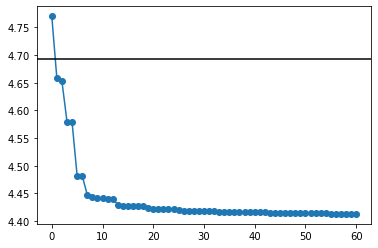

In [9]:
# model2=model.copy()
model2=barcoderegression.parameters.Model(model.B,model.K,M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F','varphi','alpha','rho','a','b'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')
plt.axhline(bestloss,color='black')

lossinfo=model2.loss(Xrav)
print('final reconstruction loss per obs',lossinfo['reconstruction']/model2.nobs)
print('final L1 loss perobs',model2.lam*lossinfo['l1']/model2.nobs)
print('final loss',lossinfo['loss'])

bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

In [42]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

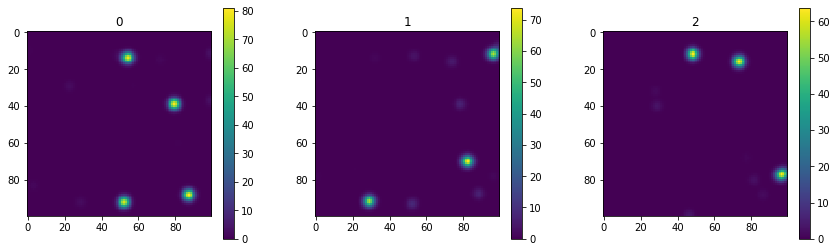

In [43]:
# we learned:
spatials(model2,spdims,blurred=True)

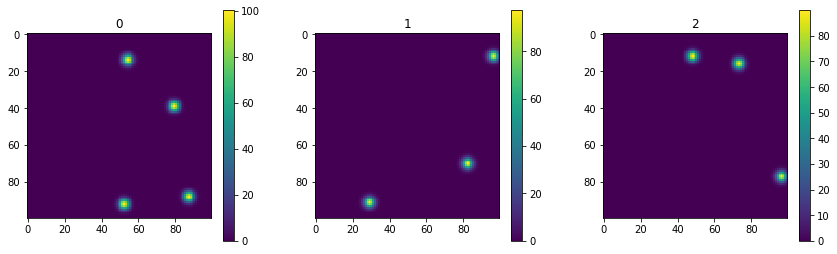

In [44]:
# truth is:
spatials(model,spdims,blurred=True)

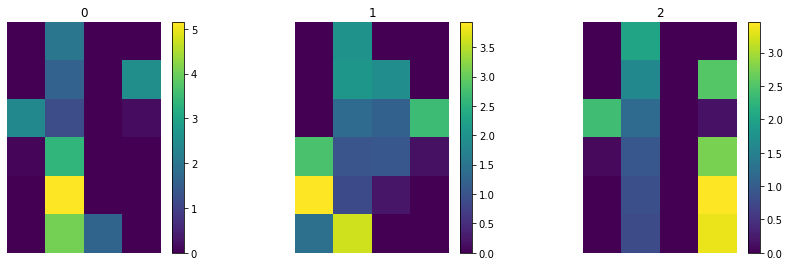

In [45]:
# we learned
frames(model2)

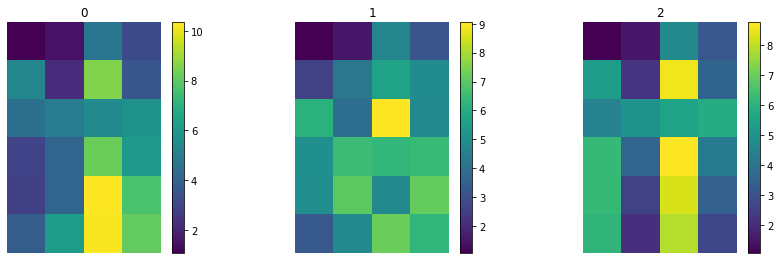

In [46]:
# truth is
frames(model)

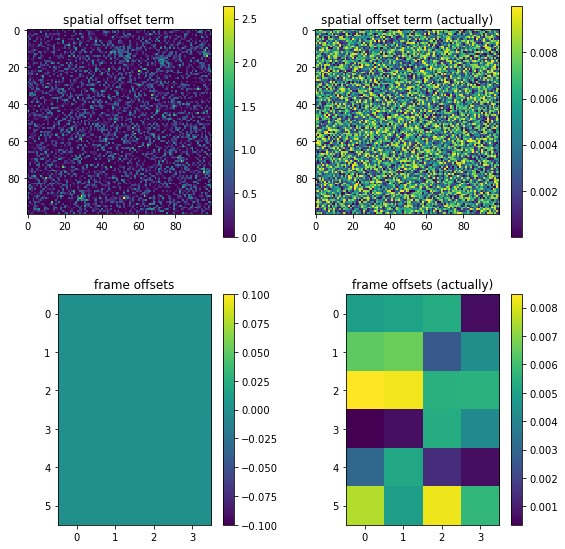

In [47]:
with AnimAcross(columns=2) as a:
    a("spatial offset term")
    a.cb(plt.imshow(model2.a.reshape(spdims)))
    
    a("spatial offset term (actually)")
    a.cb(plt.imshow(model.a.reshape(spdims)))
    
    a('frame offsets')
    a.cb(plt.imshow(model2.b))
    
    a('frame offsets (actually)')
    a.cb(plt.imshow(model.b))

In [35]:
recon=model2.reconstruction().reshape(X.shape)
rbycs(recon,X)

interactive(children=(Dropdown(description='i', options=(0, 1), value=0), Output()), _dom_classes=('widget-int…

# try on simulated data with more genes!

In [2]:
with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    X=example['data'].transpose([2,3,0,1])
    B=example['barcode'].astype(np.bool)
    R=X.shape[-2]
    C=X.shape[-1]
    Xrav=X.reshape((-1,R,C))
    spatial_dims=X.shape[:2]
    
    
with open('/home/jovyan/work/Documents/research/data/barseq/genedistr.pkl','rb') as f:
    genedistr=pickle.load(f)

In [3]:
npr.choice(5,p=np.ones(5)/5,size=3)

array([3, 0, 3])

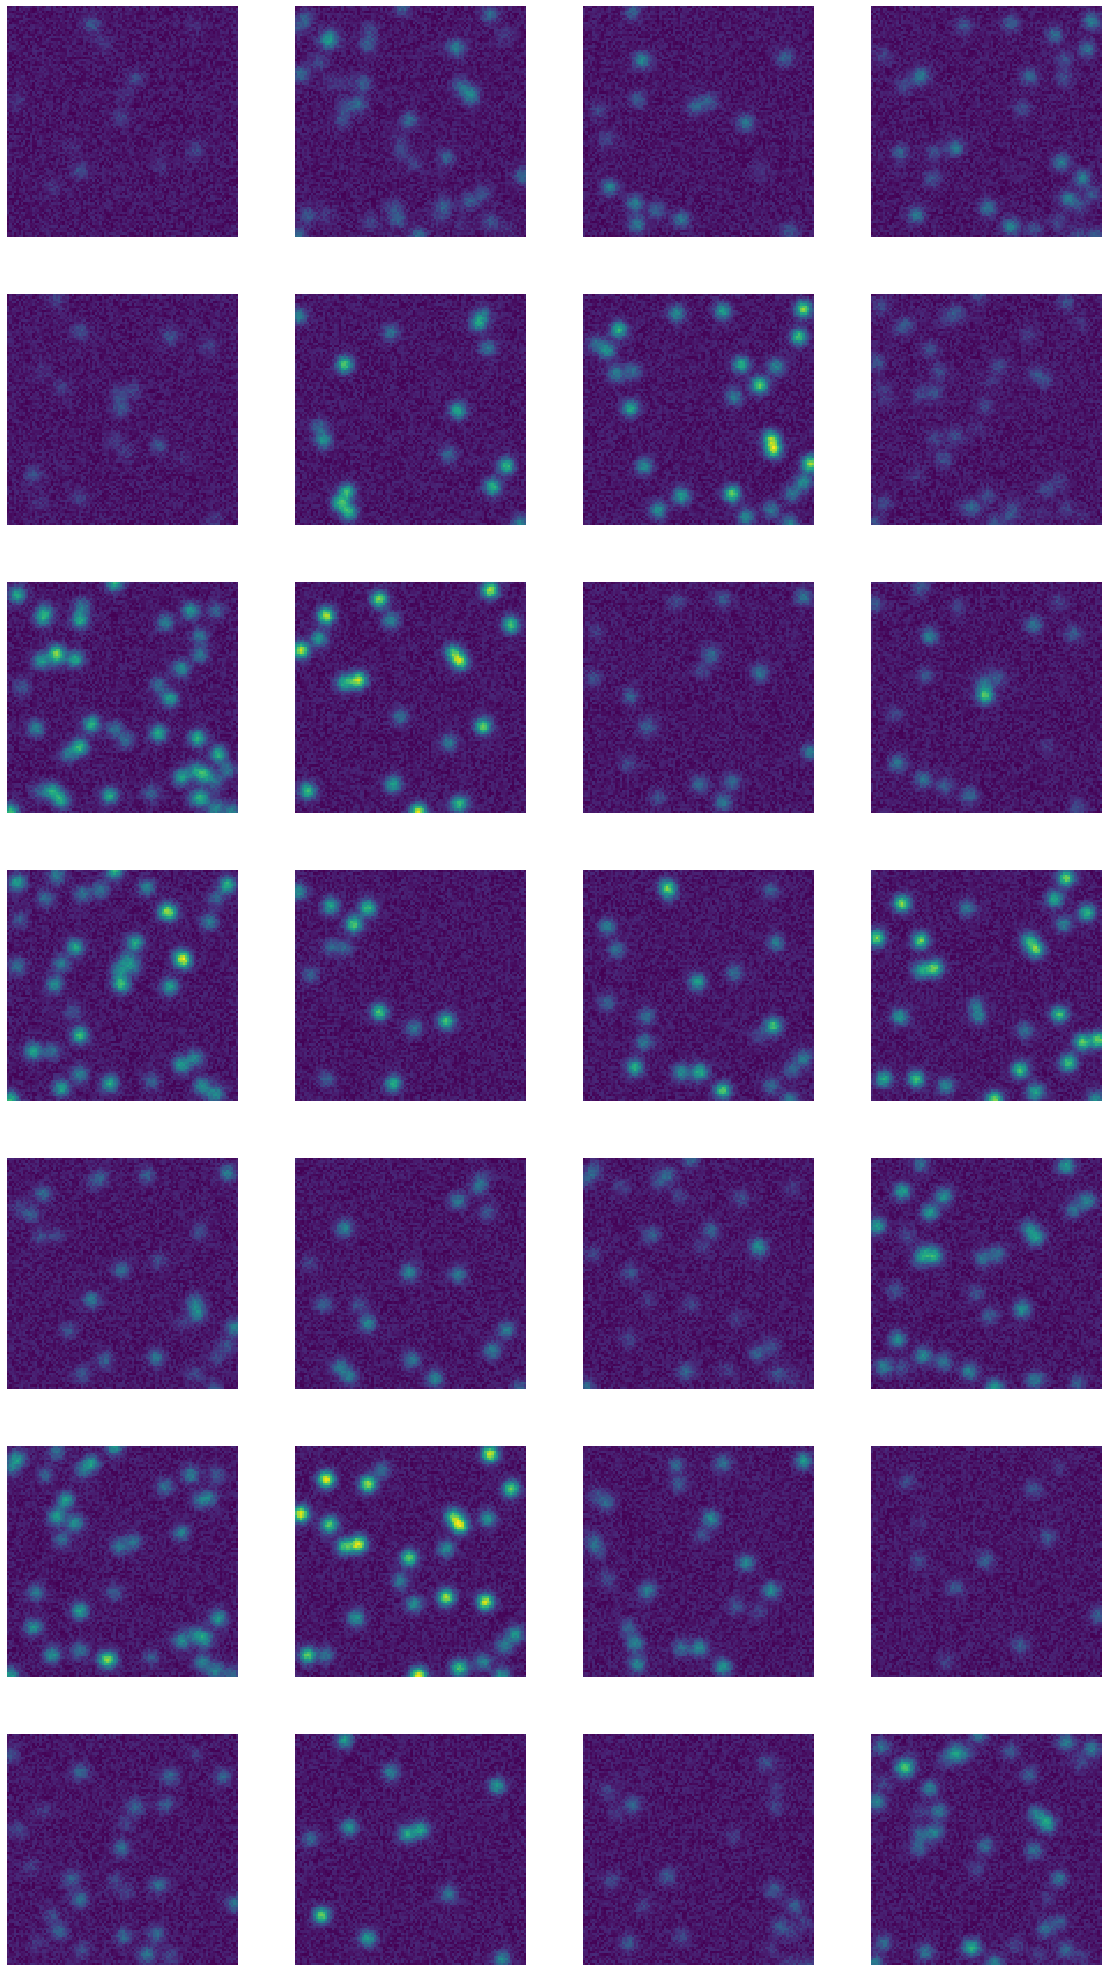

In [53]:

model,Xrav,X_without_noise = barcoderegression.simulations.simulation_from_B(
    B,spatial_dims,100,blursize=[2.5,2.5],noise=.15,genedistr=genedistr,lam=.05)
X=Xrav.reshape(spatial_dims+(R,C))
rbyc(X,cb=False)


we went wrong way 2.23251883625002e-06
final reconstruction loss per obs 0.0012713663069487825
final L1 loss perobs 0.001584056792877315
final loss 0.002855423099826097
F 339.3943635810017 -1.0109569633315676e-06
F 341.27854685917123 -2.23251883625002e-06


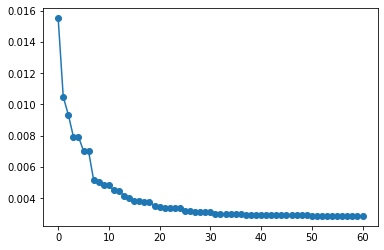

In [7]:
model2=barcoderegression.parameters.Model(
    model.B,
    barcoderegression.blurkernels.ContiguousBlur(spatial_dims,[2,2]),
    M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model2)
trange=tqdm.notebook.tqdm(range(10))
for i in trange:
    trainer.update(nms=['F','varphi','alpha','rho','a','b'])
    trange.set_description(str(trainer.losses[-1]['reconstruction']))
trainer.status()


we never went the wrong way!
final reconstruction loss per obs 0.0012237644972439535
final L1 loss perobs 0.0014355508809530152
final loss 0.0026593153781969687


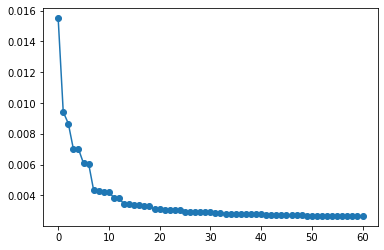

In [14]:
model3=barcoderegression.parameters.Model(
    model.B,
    barcoderegression.blurkernels.NoBlur(),
    M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model3)
trainer.train_tqdm_notebook(['F','varphi','alpha','rho','a','b'],10)
trainer.status()

In [43]:
F=model.F_scaled(blurred=True)
F2=model2.F_scaled(blurred=True)
F3=model3.F_scaled(blurred=True)
Fs=[F,F2,F3]


F=model.F_scaled(blurred=False)
F2=model2.F_scaled(blurred=False)
F3=model3.F_scaled(blurred=False)
Fs_sharp=[F,F2,F3]

nms=['F truth','learned under \n blur model ','learned without \n blur model']
def go(j=60):
    with AnimAcross(columns=len(Fs)) as a:
        for thisF,nm in zip(Fs,nms):
            a(nm+f" {j}")
#             a.cb(plt.imshow(thisF[:,j].reshape(spatial_dims)))
            plt.imshow(thisF[:,j].reshape(spatial_dims),vmax=4)
            plt.axis("off")
        
        for thisF,nm in zip(Fs_sharp,nms):
            a(nm+' (sharp)')
#             a.cb(plt.imshow(thisF[:,j].reshape(spatial_dims)))
            plt.imshow(thisF[:,j].reshape(spatial_dims),vmax=4)
            plt.axis("off")
    
# ipywidgets.interact(go,j=[22,26,27,49,60])
ipywidgets.interact(go,j=(0,model.J-1))

interactive(children=(IntSlider(value=60, description='j', max=80), Output()), _dom_classes=('widget-interact'…

<function __main__.go(j=60)>

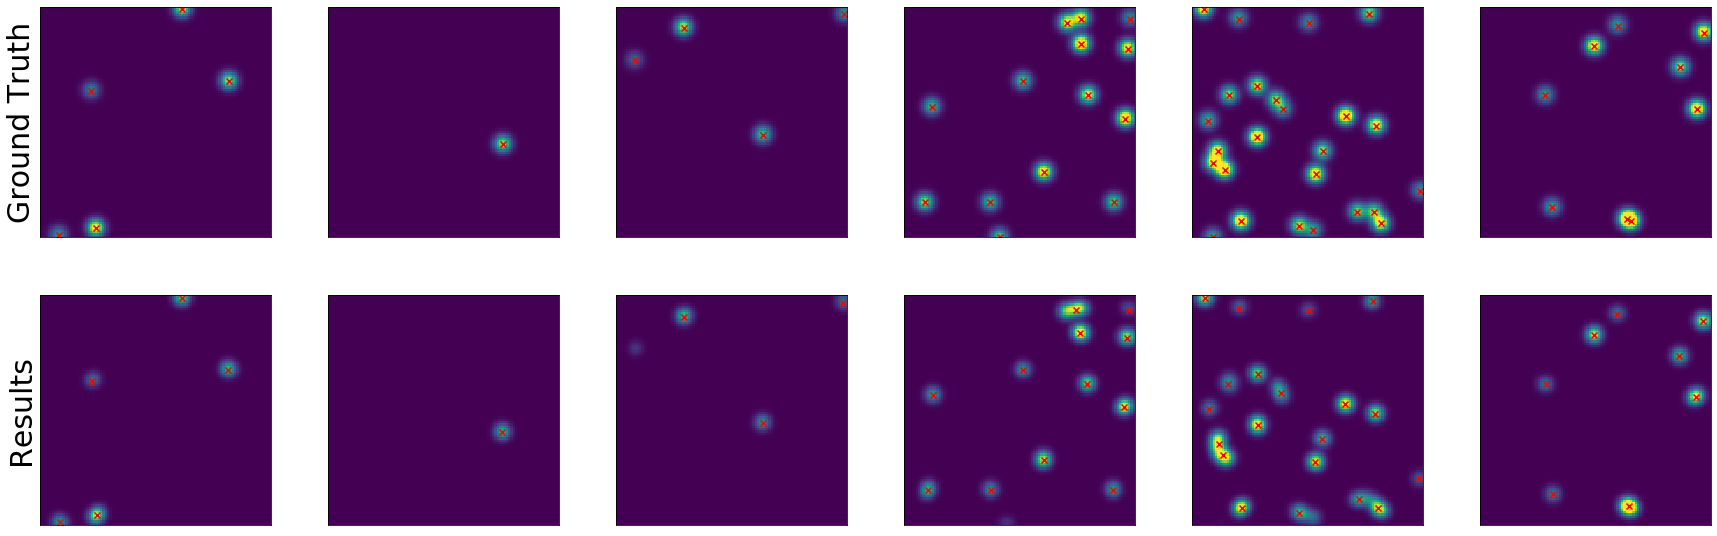

In [51]:
Fsh=model.F_scaled(blurred=False)
F=model.F_scaled(blurred=True)
F2=model2.F_scaled(blurred=True)

js=[23,26,27,49,60,77]

with AnimAcross(columns=len(js)) as a:
    for i,j in enumerate(js):
        ~a
        if i==0:
            plt.ylabel("Ground Truth",fontsize=30)
            
        pic=Fsh[:,j].reshape(spatial_dims)
        locs=np.c_[np.where(pic>0)]
            
        plt.imshow(F[:,j].reshape(spatial_dims),vmax=4)
        plt.scatter(locs[:,1],locs[:,0],marker='x',color='red')
        plt.xticks([]); plt.yticks([])
        plt.xlim(0,pic.shape[1]-1)
        plt.ylim(pic.shape[0]-1,0)

    for i,j in enumerate(js):
        ~a
        if i==0:
            plt.ylabel("Results",fontsize=30)
            
        pic=F2[:,j].reshape(spatial_dims)
        
        locs=skimage.feature.peak_local_max(pic,threshold_abs=.8)
        plt.imshow(pic,vmax=4)
        plt.scatter(locs[:,1],locs[:,0],marker='x',color='red')
        plt.xticks([]); plt.yticks([])
        

In [173]:
F=model.F_scaled(blurred=True)
F2=model2.F_scaled(blurred=True)
F3=model3.F_scaled(blurred=True)
def go(j=60):
    with AnimAcross() as a:
        a('truth')
        plt.imshow(F[:,j].reshape(spatial_dims),vmax=6)
        plt.axis('off')
        a('learned')
        plt.imshow(F2[:,j].reshape(spatial_dims),vmax=3)
        plt.axis('off')
        a('learned (without blur model)')
        plt.imshow(F3[:,j].reshape(spatial_dims),vmax=3)
        plt.axis('off')
    
ipywidgets.interact(go,j=list(range(model.J)))

interactive(children=(Dropdown(description='j', index=60, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.go(j=60)>

interactive(children=(Dropdown(description='j', index=7, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.go(j=7)>

In [67]:
import scipy.io
basecalls=sp.io.loadmat('/home/jovyan/work/Documents/research/data/barseq/basecalls.mat')

In [97]:
cts,vals=np.histogram(basecalls['id21'][:,0].astype(np.int)-1,bins=np.r_[-2:82]+.5)
cts=cts[1:-1]

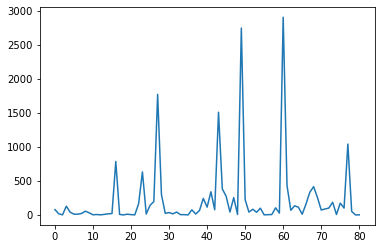

In [100]:
plt.plot(cts)

Text(0, 0.5, 'number of spots')

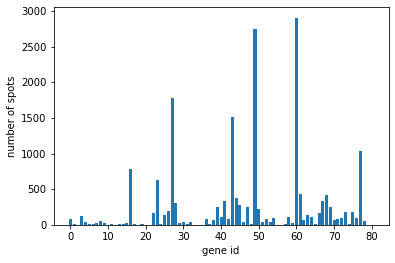

In [117]:
plt.bar(range(len(cts)),cts)
plt.xlabel("gene id")
plt.ylabel("number of spots")

In [112]:

with open('/home/jovyan/work/Documents/research/data/barseq/genedistr.pkl','wb') as f:
    pickle.dump(distr,f)

In [111]:
distr.min()

5.526693931690063e-05

In [110]:
len(distr)

81

In [109]:
distr=(1+cts)/np.sum(1+cts)

(22165, 81)

# try on real data

In [32]:
with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    X=example['data'].transpose([2,3,0,1])
    B=example['barcode'].astype(np.bool)
    R=X.shape[-2]
    C=X.shape[-1]
    Xrav=X.reshape((-1,R,C))

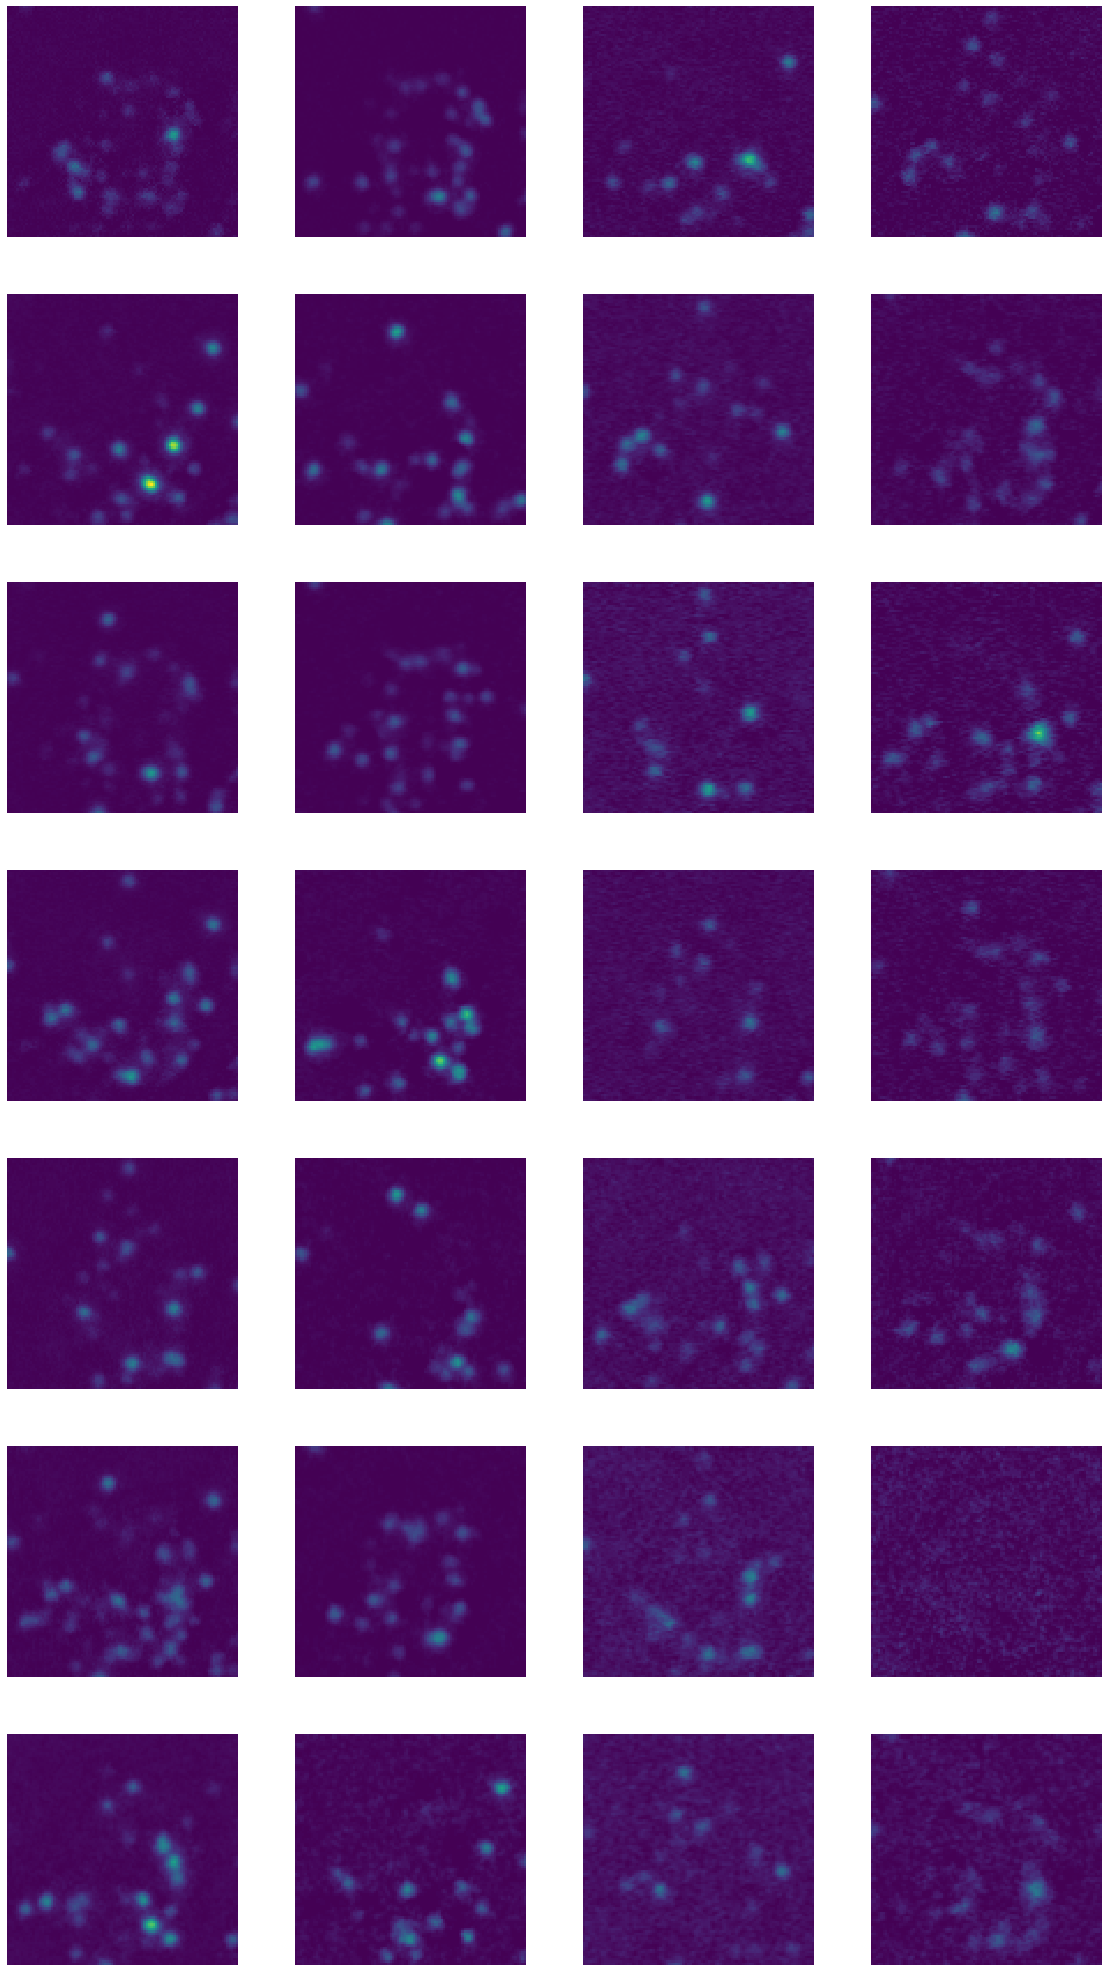

In [33]:
rbyc(X,cb=False)


we never went the wrong way!
final perpix reconstruction loss 0.3696170908415296
final perpix L1 loss 0.09760545633843173
final loss 0.4672225471799613


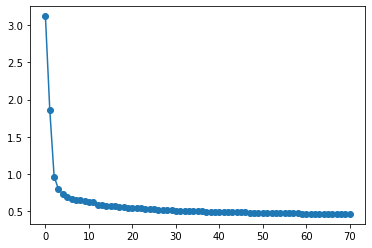

In [120]:
M=np.prod(X.shape[:-2])
model2=barcoderegression.parameters.Model(
    B,
    barcoderegression.blurkernels.ContiguousBlur(X.shape[:2],[3,3]),
    M=M,
    rho=np.ones(C)*.05,
    lam=.1)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F'])
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F','alpha','b','a','rho','varphi'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')

lossinfo=model2.loss(Xrav)
print('final perpix reconstruction loss',lossinfo['reconstruction']/(R*C*M))
print('final perpix L1 loss',model2.lam*lossinfo['l1']/(R*C*M))
print('final loss',lossinfo['loss'])

In [121]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

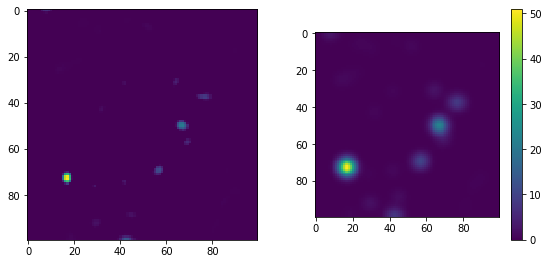

In [122]:
with AnimAcross() as a:
    ~a
    F=model2.F_scaled(blurred=False)
    plt.imshow(F[:,23].reshape(X.shape[:2]))
    ~a
    F=model2.F_scaled(blurred=True)
    a.cb(plt.imshow(F[:,23].reshape(X.shape[:2])))

In [87]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
Fb=model2.F_scaled(blurred=True).reshape(X.shape[:2]+(model2.J,))
def go(idx,thresh=22):
    plt.imshow(F[:,:,idx],vmin=0,vmax=F.max())
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh,footprint=np.ones((3,3),dtype=np.bool))
    plt.colorbar()
#     plt.axis("off")
    plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
    plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(model2.J)),thresh=(1,70))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.go(idx, thresh=22)>

In [101]:
THRESH=22
allpeaks=[]
for idx in range(model2.J):
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=THRESH)
    peaks=np.c_[np.ones(len(peaks))*idx,peaks]
    allpeaks.append(peaks)
allpeaks=np.concatenate(allpeaks,axis=0)

print('num peaks:',len(allpeaks))

# good=np.where(model2.B[1,3]*model2.B[2,1])[0]
# allpeaks=[x for x in allpeaks if (x[0] in good)]

good=np.where(model2.B[0,2]*model2.B[1,0]*model2.B[2,3])[0]
allpeaks=[x for x in allpeaks if (x[0] in good)]

# allpeaks=[x for x in allpeaks if (x[0]==60)]
# print(allpeaks)

num peaks: 309


In [103]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
Fb=model2.F_scaled(blurred=True).reshape(X.shape[:2]+(model2.J,))
def go(idx,radius):
    gene,x,y=allpeaks[idx]
    gene=int(gene)
    st=np.max([[0,0],[x-radius,y-radius]],axis=0)
    center = np.r_[x,y]-st
    en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
    sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
    with AnimAcross(columns=model2.C,sz=2) as a:
        for r in range(model2.R):
            for c in range(model2.C):
                if r==0 and c==0:
                    a(f'{gene}: {x},{y}')
                else:
                    ~a
#                 plt.imshow(X[sl+(r,c)],vmin=0,vmax=X[:,:,r,c].max())
                plt.imshow(X[sl+(r,c)])
                plt.axhline(center[0],color='red')
                plt.axvline(center[1],color='red')
                plt.axis("off")
                if model2.B[r,c,gene]:
                    plt.plot([center[1]],[center[0]],'rx',ms=20)
                    
        a('spatial loading')
        plt.imshow(F[sl+(gene,)])
        plt.axhline(center[0],color='red')
        plt.axvline(center[1],color='red')
        
        a('spatial loading')
        plt.imshow(Fb[sl+(gene,)])
        plt.axhline(center[0],color='red')
        plt.axvline(center[1],color='red')
        
        
#     peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh)
#     plt.colorbar()
#     plt.axis("off")
#     plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
#     plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(len(allpeaks))),radius=[20,10])

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), valu…

<function __main__.go(idx, radius)>

(array([60]),)

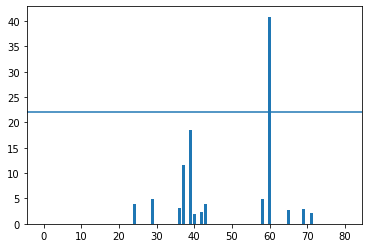

In [201]:
thisf=F.reshape(X.shape[:2]+(model2.J,))[89,49-5]
plt.bar(range(model2.J),thisf)
plt.axhline(THRESH)
np.where(thisf>THRESH)

In [192]:
allpeaks

[array([60., 89., 44.]),
 array([60., 83., 57.]),
 array([60., 76., 29.]),
 array([60., 74., 41.]),
 array([60., 69., 71.]),
 array([60., 65., 37.]),
 array([60., 60., 42.]),
 array([60., 58., 69.]),
 array([60., 37., 72.]),
 array([60., 35., 48.]),
 array([60., 34., 54.]),
 array([60., 31., 41.])]

In [128]:
peaks

array([[23., 73., 17.],
       [23., 70., 57.],
       [23., 50., 66.],
       [23., 38., 77.]])

# wiggles

88 98


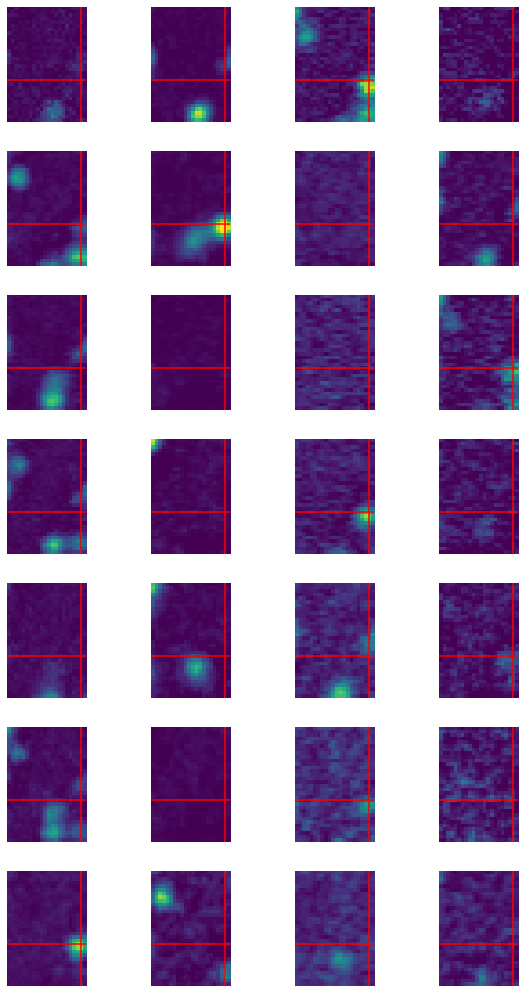

In [143]:
# x=npr.randint(0,X.shape[0])
# y=npr.randint(0,X.shape[1])
# x=88
# y=44

# x=88
# y=98

print(x,y)
radius=20
st=np.max([[0,0],[x-radius,y-radius]],axis=0)
center = np.r_[x,y]-st
en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
with AnimAcross(columns=model2.C,sz=2) as a:
    for r in range(model2.R):
        for c in range(model2.C):
            ~a
            plt.imshow(X[sl+(r,c)],vmin=0,vmax=15)
#             plt.imshow(X[sl+(r,c)])#/model2.alpha[r,c],vmin=0,vmax=15)
            plt.axhline(center[0],color='red')
            plt.axvline(center[1],color='red')
            plt.axis("off")

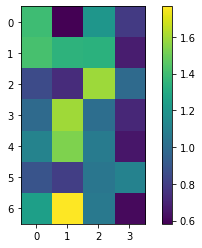

In [126]:
plt.imshow(model2.alpha)
plt.colorbar()

In [119]:
model2.alpha

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

# learn stuff

In [ ]:
barcoderegression.parameters.Barcode

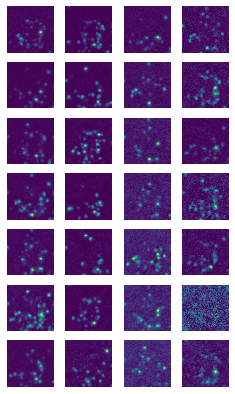

In [16]:

nby4(data)

In [9]:
data.shape

(7, 4, 100, 100)